

## **1. Load Melanoma dataset and create Dataset and DataLoader**
## **2. Create a light data augmentation transforms pipeline (identify which data augmentation techniques to use during training — just use a couple).**
## **3. Print a few images and associated labels.**


### Mounting Google Drive to access files and navigating to the directory where the dataset is located. Then, copying the dataset zip file to the content directory and unzipping it.


In [ ]:
import os
!pip install -U -q torch_snippets
from torch_snippets import *

In [ ]:
# Changing directory to the location of the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Copying the dataset zip file to the content directory
%cd /content/drive/MyDrive/midterm CV/
%cp archive.zip /content/archive.zip

/content/drive/MyDrive/midterm CV


In [ ]:
# back to content directory
%cd /content/

/content


In [ ]:
# Unzip the dataset file
!unzip -qq archive.zip

replace __MACOSX/._archive? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### Importing the necessary libraries and loading the Train and Test data folders

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as T
from torchvision.io import read_image

import cv2 as cv

# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Define paths to training and test data
train_path = '/content/train'
test_path = '/content/test'

cpu

### creating a dictionary id2int to map the class labels 'Benign' and 'Malignant' to integer values 0 and 1

In [ ]:
id2int = {'Benign': 0, 'Malignant': 1}

## **Defining the Tranformation Pipeline for Train and Validation dataset**

### Perform the transformations to be done on top of the images.

* ###  We have a pipeline of transformations on top of the input image – which is ** resizing the image** (which ensures that the minimum size of one of the dimensions is 128, in this case).
* ###  Furthermore, we are performing Affine transformations such as **rotation and translation are randomly** applied to the images. This introduces variability in the training data and helps improve the model's generalization and robustness.
* ### The images are **randomly flipped horizontally** with a probability of 0.5. This augmentation technique adds further diversity.

* ###  After the transformations, the images are **converted to PyTorch tensors **using the .ToTensor() method. This step **scales** the pixel values to the range [0, 1] and prepares the data for input to the neural network model.

* ###  Finally, the pixel values of the images are **normalized** using the specified mean and standard deviation. Normalization helps center the data around zero and scale it to have a standard deviation of one, which aids in training convergence and stability.


In [ ]:
import time
from torchvision import transforms as T

trn_tfms = T.Compose([T.ToPILImage(),
                      T.Resize(128), # 128x128
                      T.RandomAffine(5, translate=(0.01,0.1)),
                      T.RandomHorizontalFlip(),
                      T.RandomRotation(degrees=15),
                      T.ToTensor(),
                      T.Normalize(mean=[0.5, 0.5, 0.5],
                                  std=[0.5, 0.5, 0.5]), ])

### Specify the transformations to be done on the validation images.

In [ ]:
# converts input data to a PIL Image format, resize, and normalize transforms
val_tfms = T.Compose([T.ToPILImage(),
                      T.Resize(128),
                      T.ToTensor(),
                      T.Normalize(mean=[0.5, 0.5, 0.5],
                                   std=[0.5, 0.5, 0.5]), ])

### Defining the Dataset Class - MelanomaImages

In [ ]:
class MelanomaImages(Dataset):
  def __init__(self, files, transform=None):                    #  Initializes the dataset with a list of file paths
    self.files = files                                          #  (images in the dataset) and an optional transformation function.
    self.transform = transform
    logger.info(len(self))

  def __len__(self):
    return len(self.files)                                      #  Returns the total number of samples in the dataset

  def __getitem__(self, ix):
    fpath = self.files[ix]
    clss = fname(parent(fpath))                                 #  class of image
    img = read(fpath, 1)
    return img, clss

  def choose(self):
    return self[randint(len(self))]                             #  choose random image

  def collate_fn(self, batch):
    _imgs, classes = list(zip(*batch))                          #  Processes a batch of samples before they are returned by the DataLoader
    if self.transform:
      imgs = [self.transform(img)[None] for img in _imgs]                                #  including applying transformations
      classes = [torch.tensor([id2int[clss]]) for clss in classes]                       #  and converting class labels to tensors.
      imgs, classes = [torch.cat(i).to(device) for i in [imgs, classes]]
      return imgs, classes, _imgs

### Creating the Dataset and DataLoader for Train and Validate files

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import glob
trn_files = glob.glob('/content/archive/train/*/*.jpg')         # collect file names of all images
val_files = glob.glob('/content/archive/test/*/*.jpg')

# from sklearn.model_selection import train_test_split
# trn_files, val_files = train_test_split(all_files, random_state=1) # train test split

# create train and test datasets
trn_ds = MelanomaImages(trn_files, transform=trn_tfms)
val_ds = MelanomaImages(val_files, transform=val_tfms)
trn_dl = DataLoader(trn_ds, 100, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, 100, shuffle=False, collate_fn=val_ds.collate_fn)

[03/24/24 14:59:57] INFO     11879                                                                                                ]8;id=28316;file://<ipython-input-10-cf1640a0728e>:5\<ipython-input-10-cf1640a0728e>]8;;\:]8;id=485978;file://<ipython-input-10-cf1640a0728e>:5#__init__:5\__init__:5]8;;\

                    INFO     2000                                                                                                 ]8;id=53415;file://<ipython-input-10-cf1640a0728e>:5\<ipython-input-10-cf1640a0728e>]8;;\:]8;id=398873;file://<ipython-input-10-cf1640a0728e>:5#__init__:5\__init__:5]8;;\

###  Printing randomly images and checking whether they are correctly labelled.

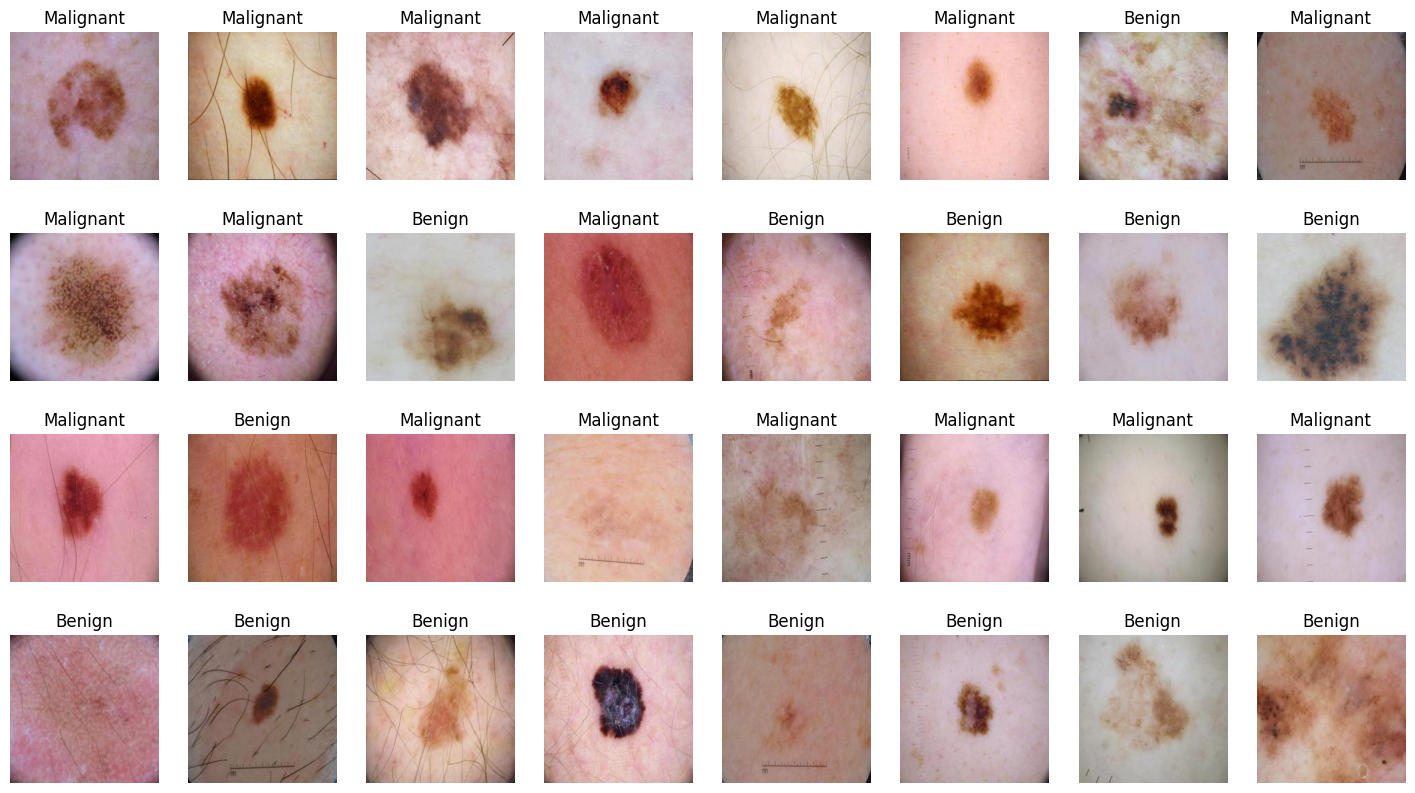

In [ ]:
fig, ax = plt.subplots(4,8, figsize=(18,10))
ax = ax.ravel()

for counter, ind in enumerate( np.random.randint(0,len(val_ds), 32) ):
    img, target = val_ds[ind]
    # img = torch.permute(img, [1, 2, 0])
    ax[counter].imshow(img)
    label = [key for key, val in val_ds if val == target][counter]
    if label.all() == 0:
      ax[counter].set_title('Benign')
    else:
      ax[counter].set_title('Malignant')
    # ax[counter].set_title(label.all())
    ax[counter].axis('off')

## **Hand-built CNN:**
## **4. Build a CNN for classification using a similar design to what we did in labs (e.g., a VGGstyle architecture with convolutions -> flattening -> fully connected; < 10 layers)**

### Define the model – MelanomaClassifier.

In [ ]:
# Convolution block
def convBlock(ni, no):
  return nn.Sequential(
    nn.Dropout(0.2),
    nn.Conv2d(ni, no, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(no),
    nn.MaxPool2d(2),
    )



# classifier model
class MelanomaClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        # Same structure of layers repeated
        convBlock(3, 64),
        convBlock(64, 64),
        convBlock(64, 128),
        convBlock(128, 256),
        convBlock(256, 512),
        convBlock(512, 64),
        nn.Flatten(),
        nn.Linear(256, 256),
        nn.Dropout(0.2),
        nn.ReLU(inplace=True),
        nn.Linear(256, len(id2int)))
    self.loss_fn = nn.CrossEntropyLoss()

  def forward(self, x):
    return self.model(x)

  def compute_metrics(self, preds, targets):
    loss = self.loss_fn(preds, targets)
    acc =(torch.max(preds, 1)[1]==targets).float().mean()
    return loss, acc

#**5.	Where should you apply drop out and how much drop out probability?**

Dropout is typically applied to fully connected layers to prevent overfitting and improve generalization by randomly dropping a certain percentage of neurons during training.

In this model, dropout is applied after each convolutional block. The dropout probability  is 0.2. This choice of dropout probability aims to prevent overfitting by randomly dropping out 20% of the units during training, encouraging the network to learn more robust features. However, the dropout probability can be adjusted based on experimentation and the specific characteristics of the dataset to achieve optimal performance.


# **6.	Where to Apply Batch Normalization and Why:**


Batch normalization is applied after the ReLU activation within each convolutional block which  helps stabilize and speed up the training process by normalizing the activations of each layer,the input to each layer remains within a stable range, facilitating better training dynamics.

It reduces the internal covariate shift, making the model more robust and faster to converge during training.



In [ ]:
#Defines EarlyStopping class
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.verbose = verbose

    def __call__(self, val_loss):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss >= self.best_score:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0

### Define the functions to train and validate on a batch of data.

In [ ]:
def train_batch(model, data, optimizer, criterion, scheduler):
  model.train()
  ims, labels, _ = data
  _preds = model(ims)
  optimizer.zero_grad()
  loss, acc = criterion(_preds, labels)
  loss.backward()
  optimizer.step()
  return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
  model.eval()
  ims, labels, _ = data
  _preds = model(ims)
  loss, acc = criterion(_preds, labels)
  return loss.item(), acc.item()

# **Training:**
# **7. Implement training and validation loop that prints out progress during each epoch, and generate model evaluation metrics (e.g., confusion matrix)**

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import torch.optim.lr_scheduler as lr_scheduler
model = MelanomaClassifier().to(device)
criterion = model.compute_metrics
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.5, patience=2)
early_stopping = EarlyStopping(patience=5, verbose=True)
print("Start Training")

train_losses = []
val_losses = []
train_accs = []
val_accs = []
t0 = time.time()
n_epochs = 5
# log functionality from torch_snippets
log = Report(n_epochs)

# Training loop
for ex in range(n_epochs):
  t1 = time.time()
  N = len(trn_dl)
  train_loss = 0
  train_acc = 0
  for bx, data in enumerate(trn_dl):
    loss, acc = train_batch(model, data, optimizer, criterion, scheduler)
    train_loss = loss
    # train_losses.append(train_loss/len(trn_dl))
    train_acc = acc
    # train_accs.append(train_acc/len(trn_dl))
    log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')
    # print("Epoch: {}/{}  ".format(ex+(bx+1), ex),
        # "Training loss: {:.4f}  ".format(train_loss/len(trn_dl)),
        # "Training accuracy: {:.4f}  ".format(train_acc/len(trn_dl)))

  # Validation loop
  val_loss = 0
  val_acc= 0
  N = len(val_dl)
  for bx, data in enumerate(val_dl):
    loss, acc = validate_batch(model, data, criterion)
    val_acc = acc
    # val_accs.append(val_acc/len(val_dl))
    val_loss = loss
    # val_losses.append(val_loss/len(val_dl))
    log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')
    # print("Validation loss: {:.4f}  ".format(val_loss/len(val_dl)),
          # "Validation accuracy: {:.4f}  ".format(val_acc/len(val_dl)),
          # "Epoch time: {:.4f}  ".format(time.time() - t1))

  #log.report_avgs(ex+1)
  train_losses.append(train_loss)
  # writer.add_scalar('training loss', train_loss, ex+1)
  val_losses.append(val_loss)
  # writer.add_scalar('validation loss', val_loss.cpu().numpy(), ex+1)
  train_accs.append(train_acc)
  val_accs.append(val_acc)

  print("Epoch: {}/{}  ".format(ex+1, ex),
         "Training loss: {:.4f}  ".format(train_loss),
          "Validation loss: {:.4f}  ".format(val_loss),
          "Training accuracy: {:.4f}  ".format(train_acc),
          "Validation accuracy: {:.4f}  ".format(val_acc),
          "Epoch time: {:.4f}  ".format(time.time() - t1))

  print("Training Complete")
  print("Total Elapsed Time: {:.4f} ".format(time.time() - t0))
  # writer.flush()

  # Check for early stopping
  early_stopping(val_loss)
  if early_stopping.early_stop:
     print("Early stopping")
     break

  # Adjust learning rate
  scheduler.step(val_loss)


Start Training

EPOCH: 1.000  val_loss: 0.735  val_acc: 0.570  (1437.60s - 5750.42s remaining)

Epoch: 1/0   Training loss: 0.3461   Validation loss: 0.7354   Training accuracy: 0.8101   Validation accuracy: 
0.5700   Epoch time: 1437.6047

Training Complete

Total Elapsed Time: 1437.6180

EPOCH: 2.000  val_loss: 0.648  val_acc: 0.640  (2869.34s - 4304.02s remaining)

Epoch: 2/1   Training loss: 0.3050   Validation loss: 0.6478   Training accuracy: 0.8987   Validation accuracy: 
0.6400   Epoch time: 1431.7242

Training Complete

Total Elapsed Time: 2869.3603

EPOCH: 3.000  val_loss: 0.610  val_acc: 0.670  (4248.50s - 2832.34s remaining)

Epoch: 3/2   Training loss: 0.2841   Validation loss: 0.6099   Training accuracy: 0.8608   Validation accuracy: 
0.6700   Epoch time: 1379.1403

Training Complete

Total Elapsed Time: 4248.5151

EPOCH: 4.000  val_loss: 0.500  val_acc: 0.740  (5558.56s - 1389.64s remaining)

Epoch: 4/3   Training loss: 0.4242   Validation loss: 0.5000   Training accuracy: 0.8354   Validation accuracy: 
0.7400   Epoch time: 1310.0366

Training Complete

Total Elapsed Time: 5558.5649

EPOCH: 5.000  val_loss: 0.405  val_acc: 0.820  (6850.61s - 0.00s remaining)

Epoch: 5/4   Training loss: 0.3410   Validation loss: 0.4054   Training accuracy: 0.8734   Validation accuracy: 
0.8200   Epoch time: 1292.0488

Training Complete

Total Elapsed Time: 6850.6235

#**8. How would you implement early stopping?**

 EarlyStopping track the validation loss during model training. If the validation loss does not decrease for a consecutive number of epochs[patience value = 5], the training process is terminated prematurely.

# **9. How do you interpret your loss curves?**

The loss curves show the trend of training and validation losses over epochs. A decreasing training loss indicates that the model is learning from the data, while the gap between training and validation losses indicates overfitting. Early stopping can be used if the validation loss starts increasing or stops decreasing while the training loss continues to decrease.



### While the training loss gradually decreased with each epoch, indicating that the model was learning from the training data, the validation loss also decreased initially but showed signs of stabilizing or even increasing slightly towards the end. This suggests that the model might have started to overfit the training data as training progressed.

# **10. Question: Which data augmentations are you using and why?**

The transformations include random affine transformations, random horizontal flips, and random rotations. Rotating the image by a random angle can help the model learn to recognize objects from different angles. These augmentations help increase the diversity of the training data, making the model more robust and improving its generalization performance.

# **11. Question: Which optimizer are you using and why?**


Adam optimizer is used in both hand-built CNN and transfer learning. Adam optimizer is known for its adaptive learning rate method, which computes individual adaptive learning rates for different parameters, making it suitable for training deep neural networks.

# **12.Which loss function and why?**

Cross-entropy loss is used for both hand-built CNN and transfer learning. Cross-entropy loss is commonly used for classification tasks, especially in binary or multi-class classification, as it measures the dissimilarity between the predicted probability distributions and the actual label distribution

# **13. Apply learning rate scheduler. Which one did you choose and why?**


A ReduceLROnPlateau scheduler is used. This scheduler reduces the learning rate when the validation loss plateaus, helping the model to converge faster and achieve better performance.

In [ ]:
# Save model
#torch.save(model.state_dict(), '/content/archive')
torch.save(model.state_dict(), 'model.pth')

In [ ]:
import os

# Check if the model file exists
if os.path.exists('model.pth'):
    print("Model saved successfully!")
else:
    print("Model not saved.")


Model saved successfully!

In [ ]:
from google.colab import files

# Download the saved model file
files.download('model.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [109]:
# load model
# LOAD SAVED MODEL
model = MelanomaClassifier().to(device)

model.to(device)

state_dict = torch.load('/content/drive/MyDrive/midterm CV/archive/model.pth')

# Update the model state
model.load_state_dict(state_dict)

<All keys matched successfully>

## **Evaluation matrix**

In [ ]:
# Initialize variables for accuracy calculation
total_preds = []
total_labels = []

# Iterate over the validation dataset to get predictions and labels
model.eval()
with torch.no_grad():
    for inputs, labels, _ in val_dl:  # Update to unpack three values: inputs, labels, _
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        total_preds.extend(preds.cpu().numpy())
        total_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(total_labels, total_preds)  # Use accuracy_score from sklearn.metrics

# Calculate confusion matrix
conf_matrix = confusion_matrix(total_labels, total_preds)

print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.8020

Confusion Matrix:

[[815 185]
 [211 789]]

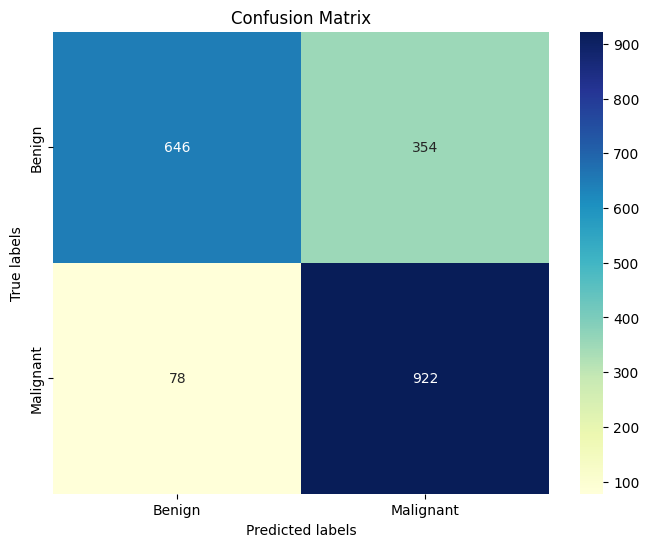

Precision: 0.723

Recall: 0.922

F1 Score: 0.810

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Plot confusion matrix with a different colormap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=['Benign', 'Malignant'],
            yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate precision, recall, and F1 score
precision = precision_score(total_labels, total_preds)
recall = recall_score(total_labels, total_preds)
f1 = f1_score(total_labels, total_preds)

print("Precision:", "%.3f" % precision)
print("Recall:", "%.3f" % recall)
print("F1 Score:", "%.3f" % f1)


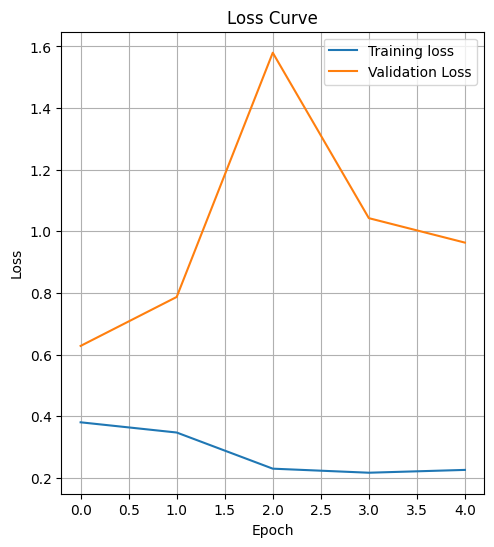

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid()
plt.show()

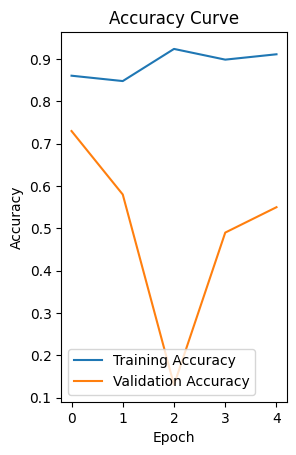

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

# **14. Generate gradient class activation maps for ‘malignant’ class. How do you interpret them?**

Grad-CAM (Gradient-weighted Class Activation Mapping) technique. Grad-CAM is a popular method for visualizing the regions of an image that are important for making a particular prediction by leveraging the gradients of the target class score with respect to the feature maps of a convolutional neural network.

interpretation the CAMs:

Areas of the image that are highlighted by the CAM represent the regions that contributed the most to the prediction of the 'malignant' class.
Strong activation in certain regions indicates that those areas contain features highly correlated with malignant characteristics, such as irregular borders or asymmetric patterns.
The CAMs provide insight into which parts of the image the model is focusing on when making predictions, aiding in understanding its decision-making process.










In [110]:
#To go from image to feature map, construct a new model by combining specific layers of existing model
#Sequential: process data through layers in a defined order, using the first 5 layers of the model (index 0 - 4) + the first 2 children components of 6th layer (index 5)

im2fmap = nn.Sequential(*(list(model.model[:5].children()) + list(model.model[5][:2].children())))

In [111]:
# print out im2fmap model
im2fmap

Sequential(
  (0): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU(inplace=True)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU(inplace=True)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU(inplace=True)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

In [112]:
##Define the im2gradCAM function that takes an input image and
#fetches the heatmap corresponding to activations of the image.
def im2gradCAM(x):
    model.eval()

    # compute output logits of model
    logits = model(x)

    heatmaps = []

    # get feature maps from last conv layer
    activations = im2fmap(x)
    print(activations.shape)

    # get the model's prediction, first element contains value,
    # second element contains index, so [-1] is index of max prediction)
    pred = logits.max(-1)[-1]

    model.zero_grad()

    #get models' most confident logit defined by pred index and computes the
    #gradient of the selected logit with respect to all the model's parameters
    logits[0,pred].backward(retain_graph=True)

    # get the gradients at the required featuremap location [-6] [1] (last conv layer)
    # and take the avg gradient for each featuremap (mean of all parameter gradients)
    # single scalar value per feature map
    pooled_grads = model.model[-6][1].weight.grad.data.mean((1,2,3))

    # multiply each activation map with corresponding gradient average
    # activations dimensions are batch size, channel (feature map), height, width
    # weighing the activation based on how much they are responsible for output:
    # how much changing the filter's weights (that produced this feature map) is expected to impact the model's prediction.
    for i in range(activations.shape[1]): #shape[1] is number of feature maps
        activations[:,i,:,:] *= pooled_grads[i]

    # take the mean of all weighted activation maps
    # calculates the mean across the dimension 1 (num_feature_maps)
    # changes size from [batchsize, 64, height, width] -> [batchsize, height, width]
    # output a single 2d heatmap for each image in batch -> average activation across all feature maps for each spatial location
    heatmap = torch.mean(activations, dim=1)[0].cpu().detach()
    return heatmap, 'Uninfected' if pred.item() else 'Parasitized'


### Define the upsampleHeatmap function to up-sample the heatmap to a shape that corresponds to the shape of the image. We are de-normalizing the image and also overlaying the heatmap on top of the image.

In [113]:
SZ = 128
def upsampleHeatmap(map, img):
  m,M = map.min(), map.max()
  map = 255 * ((map-m) / (M-m)) # denormalize image, subtract min value and divide by range
  map = np.uint8(map) # convert to unsigned 8 bit int
  map = cv2.resize(map, (SZ,SZ)) # resize image
  map = cv2.applyColorMap(255-map, cv2.COLORMAP_JET) # apply colormap
  map = np.uint8(map) # convert to int again
  map = np.uint8(map*0.7 + img*0.3) # combine heatmap and image
  return map

### Display heatmap for N images

torch.Size([1, 64, 4, 4])

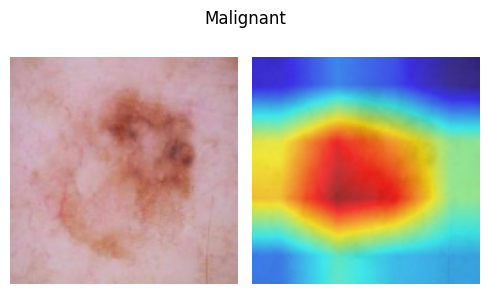

torch.Size([1, 64, 4, 4])

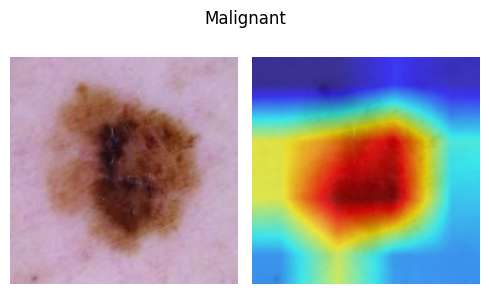

torch.Size([1, 64, 4, 4])

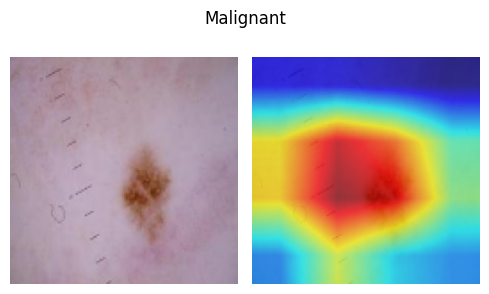

torch.Size([1, 64, 4, 4])

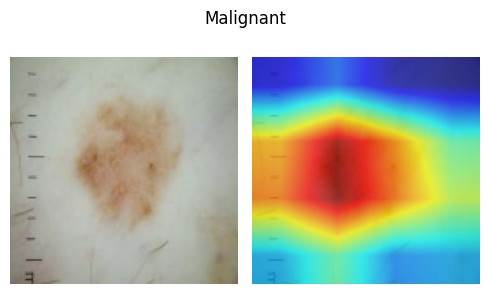

torch.Size([1, 64, 4, 4])

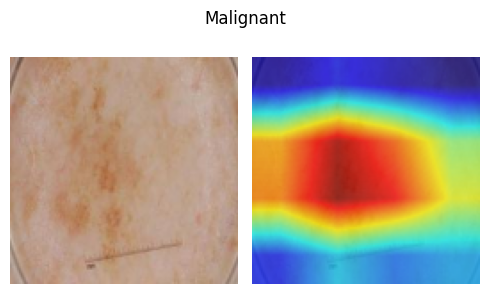

torch.Size([1, 64, 4, 4])

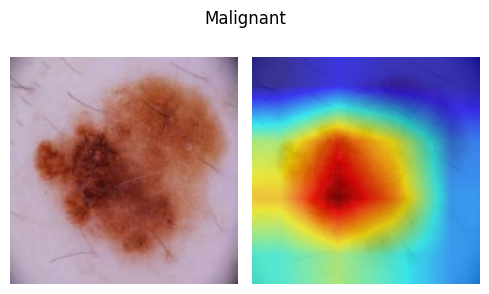

torch.Size([1, 64, 4, 4])

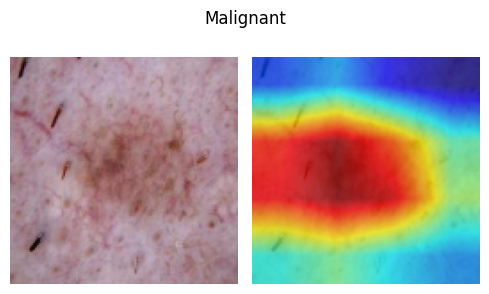

torch.Size([1, 64, 4, 4])

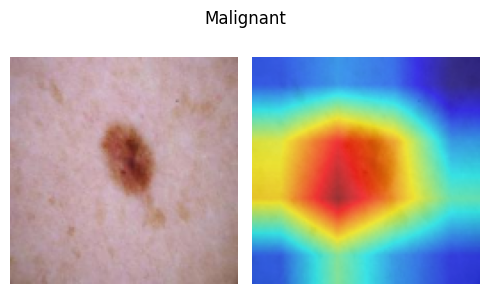

torch.Size([1, 64, 4, 4])

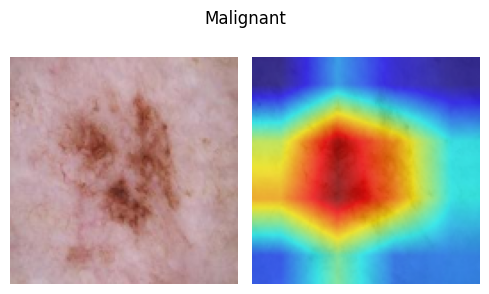

torch.Size([1, 64, 4, 4])

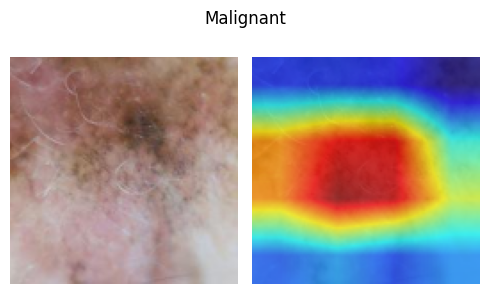

torch.Size([1, 64, 4, 4])

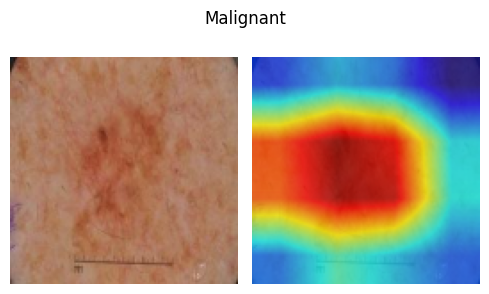

torch.Size([1, 64, 4, 4])

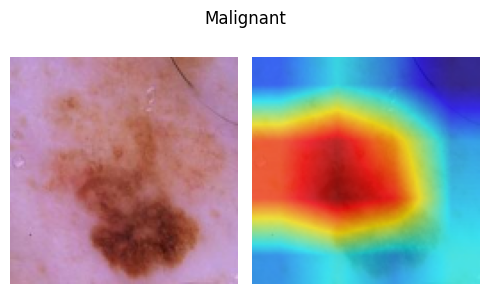

torch.Size([1, 64, 4, 4])

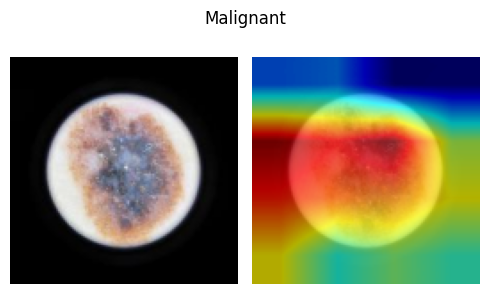

torch.Size([1, 64, 4, 4])

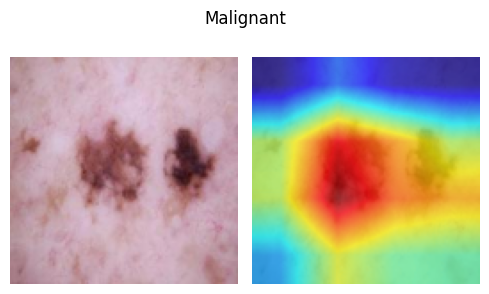

torch.Size([1, 64, 4, 4])

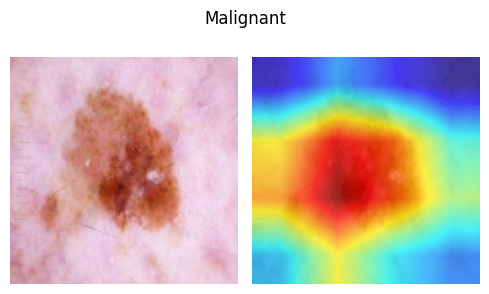

torch.Size([1, 64, 4, 4])

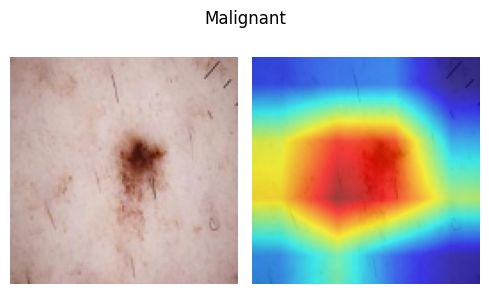

torch.Size([1, 64, 4, 4])

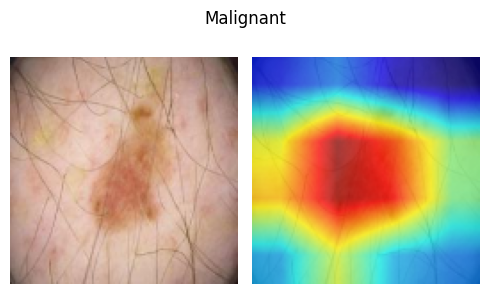

torch.Size([1, 64, 4, 4])

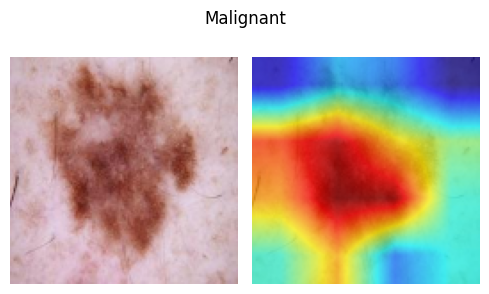

torch.Size([1, 64, 4, 4])

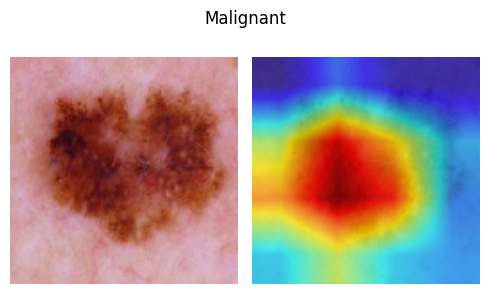

torch.Size([1, 64, 4, 4])

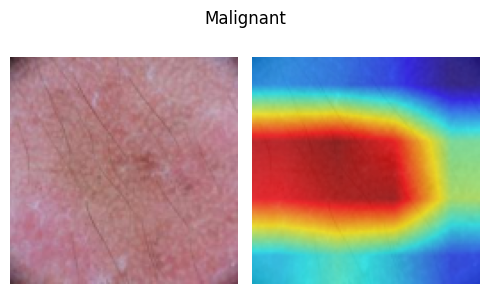

torch.Size([1, 64, 4, 4])

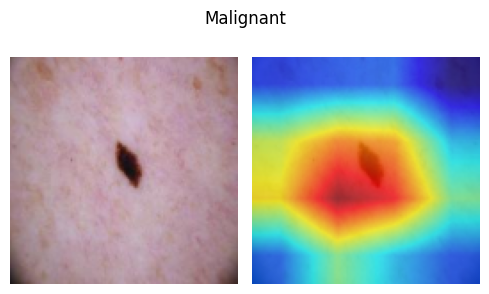

torch.Size([1, 64, 4, 4])

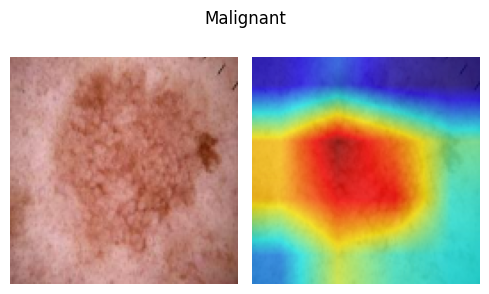

torch.Size([1, 64, 4, 4])

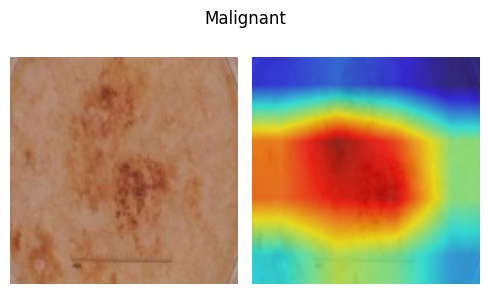

torch.Size([1, 64, 4, 4])

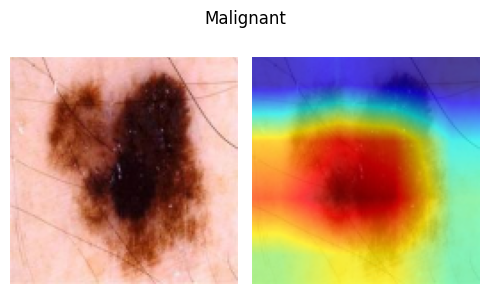

torch.Size([1, 64, 4, 4])

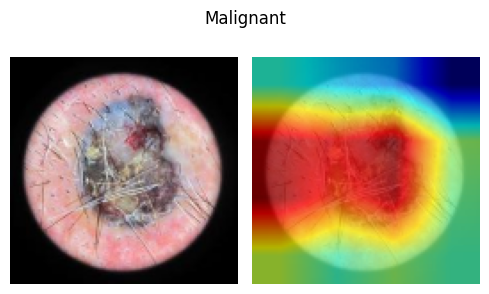

torch.Size([1, 64, 4, 4])

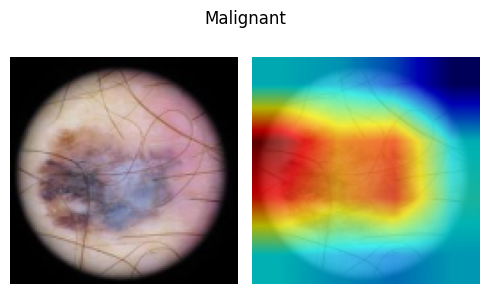

torch.Size([1, 64, 4, 4])

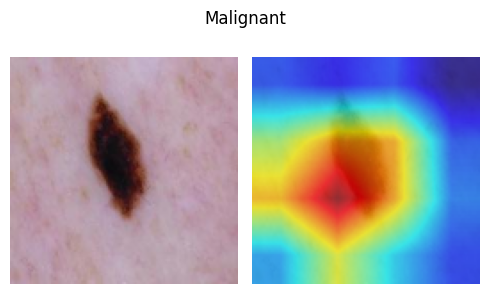

torch.Size([1, 64, 4, 4])

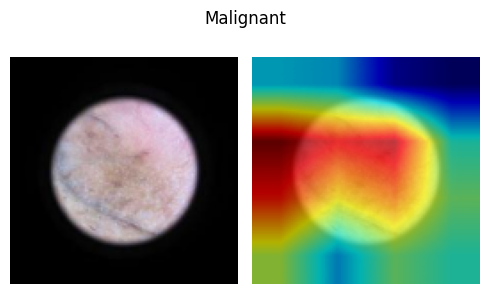

torch.Size([1, 64, 4, 4])

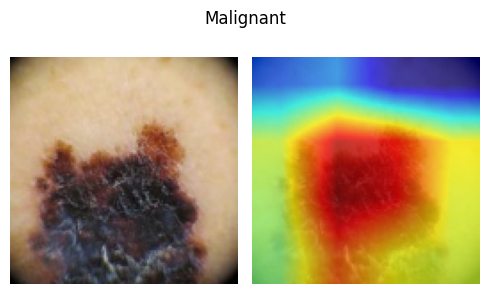

torch.Size([1, 64, 4, 4])

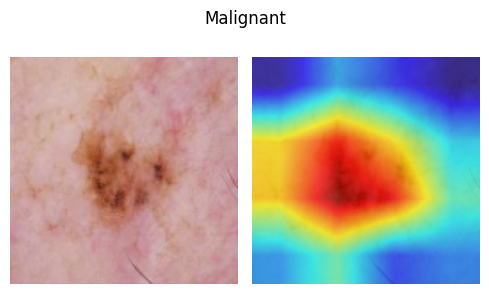

In [ ]:
N = 30
#_val_dl = DataLoader(val_ds, batch_size=N, shuffle=True, collate_fn=val_ds.collate_fn)
x,y,z = next(iter(val_dl))
# display heatmap for N Malignant images
for i in range(N):
  image = resize(z[i], SZ)
  heatmap, pred = im2gradCAM(x[i:i+1])
  if(pred=='Benign'):
    continue
  heatmap = upsampleHeatmap(heatmap, image)
  subplots([image, heatmap], nc=2, figsize=(5,3), suptitle=pred)

## **Transfer Learning:**
## **15. Implement a pretrained resnet18 for transfer learning as a feature extractor (change the classification layer).**


Implemented transfer learning using a pre-trained ResNet-18 model as a feature extractor. I froze the pre-trained layers, modified the classification layer for binary classification, and trained the model for 5 epochs using the Adam optimizer with a learning rate scheduler. Finally, evaluated the trained model's performance on both the training and validation datasets.


## **16. Implement training and validation loop that prints out progress during each epoch (max of 5 epochs), and generate model evaluation metrics (e.g., confusion matrix)**

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 130MB/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

Epoch 1/5:

Training Loss: 0.4231, Accuracy: 0.8071

Validation Loss: 0.4441, Accuracy: 0.8050

Epoch 2/5:

Training Loss: 0.3598, Accuracy: 0.8404

Validation Loss: 0.4001, Accuracy: 0.8195

Epoch 3/5:

Training Loss: 0.3491, Accuracy: 0.8464

Validation Loss: 0.3929, Accuracy: 0.8265

Epoch 4/5:

Training Loss: 0.3369, Accuracy: 0.8541

Validation Loss: 0.3968, Accuracy: 0.8270

Epoch 5/5:

Training Loss: 0.3421, Accuracy: 0.8506

Validation Loss: 0.4397, Accuracy: 0.8080

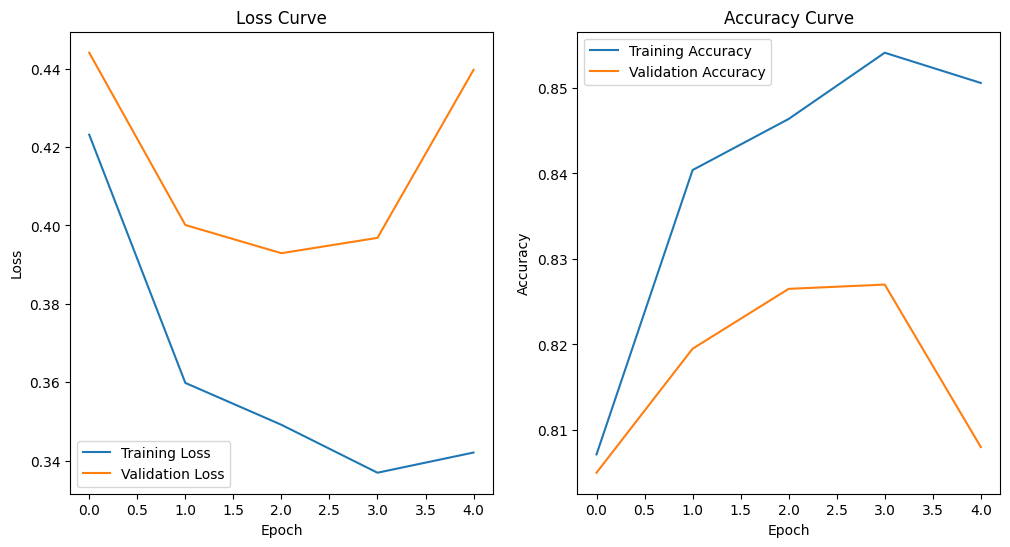

NameError: name 'evaluate_model' is not defined

In [ ]:
import torchvision.models as models

# Load pre-trained ResNet-18 model
pretrained_resnet = models.resnet18(pretrained=True)

# Freeze the pre-trained layers
for param in pretrained_resnet.parameters():
    param.requires_grad = False

# Modify the classification layer for binary classification
num_ftrs = pretrained_resnet.fc.in_features
pretrained_resnet.fc = nn.Linear(num_ftrs, 2)

# Move the model to the device
pretrained_resnet = pretrained_resnet.to(device)

# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_resnet.fc.parameters(), lr=0.001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, verbose=True)

# Define training function
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}:')

        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels, _ in trn_dl:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        train_loss = running_loss / len(trn_dl.dataset)
        train_acc = correct_train / total_train
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        print(f'Training Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}')

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels, _ in val_dl:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        val_loss = running_loss / len(val_dl.dataset)
        val_acc = correct_val / total_val
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}')

        # Adjust learning rate
        scheduler.step(val_loss)

    # Plot loss and accuracy curves
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()
    plt.show()

    # Return the trained model
    return model

# Train the model with 5 epochs
trained_resnet = train_model(pretrained_resnet, criterion, optimizer, scheduler, num_epochs=5)

# Evaluate the model
train_accuracy, train_cm = evaluate_model(trained_resnet, trn_dl)
val_accuracy, val_cm = evaluate_model(trained_resnet, val_dl)

print(f'Training Accuracy: {train_accuracy:.4f}')
print('Training Confusion Matrix:')
print(train_cm)
print(f'Validation Accuracy: {val_accuracy:.4f}')
print('Validation Confusion Matrix:')
print(val_cm)


In [ ]:
# Save model
#torch.save(model.state_dict(), '/content/archive')
torch.save(model.state_dict(), 'pretrainedmodel.pth')


In [ ]:
import os

# Check if the model file exists
if os.path.exists('pretrainedmodel.pth'):
    print("Model saved successfully!")
else:
    print("Model not saved.")


Model saved successfully!

In [ ]:
from google.colab import files

# Download the saved model file
files.download('pretrainedmodel.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [117]:
# load pretrained model
# LOAD SAVED MODEL
model = MelanomaClassifier().to(device)

model.to(device)

state_dict = torch.load('/content/pretrainedmodel.pth')

# Update the model state
model.load_state_dict(state_dict)

<All keys matched successfully>

## **Evaluation matrix**

In [ ]:
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

# Initialize variables for accuracy calculation
total_preds = []
total_labels = []

# Iterate over the validation dataset to get predictions and labels
trained_resnet.eval()
with torch.no_grad():
    for inputs, labels, _ in val_dl:  # Update to unpack three values: inputs, labels, _
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = trained_resnet(inputs)
        _, preds = torch.max(outputs, 1)
        total_preds.extend(preds.cpu().numpy())
        total_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(total_labels, total_preds)  # Use accuracy_score from sklearn.metrics

# Calculate confusion matrix
conf_matrix = confusion_matrix(total_labels, total_preds)

print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.8230

Confusion Matrix:

[[722 278]
 [ 76 924]]

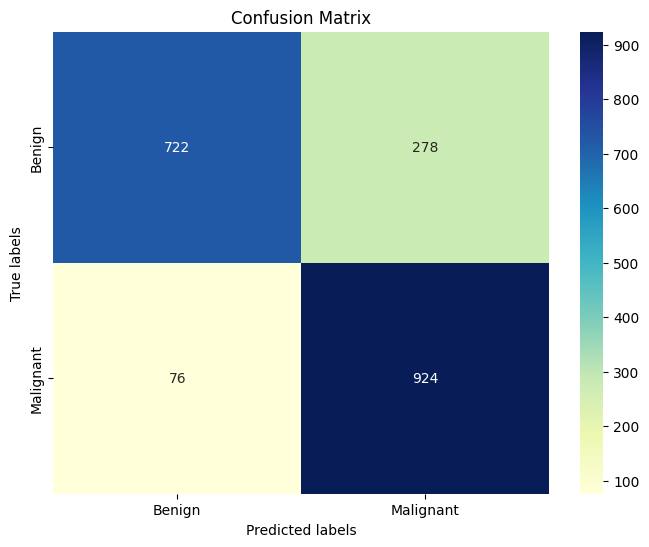

Precision: 0.769

Recall: 0.924

F1 Score: 0.839

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate confusion matrix
conf_matrix = confusion_matrix(total_labels, total_preds)

# Plot confusion matrix with a different colormap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=['Benign', 'Malignant'],
            yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate precision, recall, and F1 score
precision = precision_score(total_labels, total_preds)
recall = recall_score(total_labels, total_preds)
f1 = f1_score(total_labels, total_preds)

print("Precision:", "%.3f" % precision)
print("Recall:", "%.3f" % recall)
print("F1 Score:", "%.3f" % f1)



# **17.Compare / contrast network performance with hand-built conv net**


Comparing the performance of the network with a hand-built CNN, the pre-trained ResNet-18 model achieved an accuracy of 82.0% on the validation set, with a confusion matrix showing 722 true negatives, 278 false positives, 76 false negatives, and 924 true positives

On the other hand, the hand-built CNN achieved an accuracy of 80.2% on the validation set, with a confusion matrix showing 646 true negatives, 354 false positives, 78 false negatives, and 922 true positives.

**Overall, the pre-trained ResNet-18 model outperformed the hand-built CNN in terms of accuracy, precision, Recall and F1-score.**